In [1]:
""" (LS GAN)
Least Squares GAN

https://arxiv.org/pdf/1611.04076.pdf

Tackles the vanishing gradients problem associated with GANs by swapping out
the cross entropy loss function with the least squares (L2) loss function. The authors
show that minimizing this objective is equivalent to minimizing the Pearson chi-squared 
divergence. They claim that using the L2 loss function penalizes samples that appear to 
be real to the discriminator, but lie far away from the decision boundary. In this way, 
the generated images are made to appear closer to real data. It also stabilizes training.

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_var(x):
    """ function to automatically cudarize.. """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [23]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim, output_dim):
        """ Critic (not trained to classify). Input is an image (real or generated), output is approximate LS divergence """
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination
    
class LSGAN(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim, output_dim = 1):
        """ Super class to contain both Discriminator / Critic (D) and Generator (G) """
        super(LSGAN, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim
            
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 1e-4, D_lr = 1e-4, D_steps = 2):
        """ Train a Least Squares GAN
            Logs progress using G loss, D loss, visualizations of Generator output.

        Inputs:
            model: class, initialized LSGAN module
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: int, training step ratio for how often to train D compared to G (default 2)
        Outputs:
            model: trained LSGAN instance """
        # Adam optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr)
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps 
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator using L2 loss
                    D_loss = self.train_D(model, images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss)
                
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                                                        
                # TRAINING G: Zero out gradients for G. 
                G_optimizer.zero_grad()

                # Train the generator using L2 loss
                G_loss = self.train_G(model, images)             

                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss)
                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses)))
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
            
        return model
    
    def train_D(self, model, images):
        """ Run 1 step of training for discriminator

        Input:
            model: model instantiation
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: L2 loss for discriminator, 0.50 * E[(D(x) - a)^2] + 0.50 * E[(D(G(z)) - b)^2], 
                    where a and b are labels for generated (0) and real (1) data
        """ 
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = model.D(images) # D(x)
        DG_score = model.D(G_output) # D(G(z))
        
        # Compute L2 loss for D
        D_loss = (0.50 * torch.mean((DX_score - 1)**2)) + (0.50 * torch.mean(DG_score**2))
        
        return D_loss
    
    def train_G(self, model, images):
        """ Run 1 step of training for generator
        
        Input:
            model: instantiated GAN
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: L2 loss for G,  0.50 * E[(D(G(z)) - c)^2], 
                    where c is the label for true images (1)
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], model.z_dim) # z
        G_output = model.G(noise) # G(z)
        DG_score = model.D(G_output) # D(G(z))
        
        # Compute L2 loss for G,
        G_loss = 0.50 * torch.mean((DG_score - 1)**2)
        
        return G_loss
    
    def compute_noise(self, batch_size, image_size):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, image_size))
    
    def generate_images(self, model, epoch, num_outputs = 25, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/ls-gan/'):
                os.makedirs('../viz/ls-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/ls-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images

    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath + 'saved_gan.pth')
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = LSGAN()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model


Epoch[1/25], G Loss: 0.3765, D Loss: 0.0590


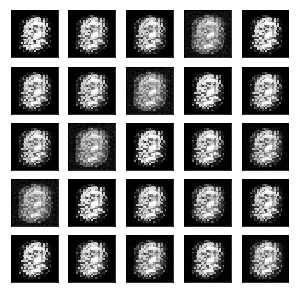

Epoch[2/25], G Loss: 0.3694, D Loss: 0.0345


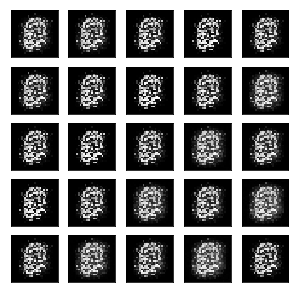

Epoch[3/25], G Loss: 0.3412, D Loss: 0.0364


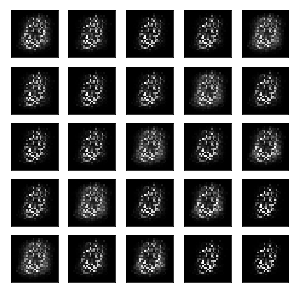

Epoch[4/25], G Loss: 0.2749, D Loss: 0.0667


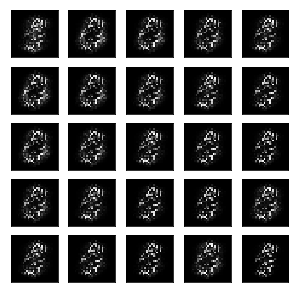

Epoch[5/25], G Loss: 0.3399, D Loss: 0.0395


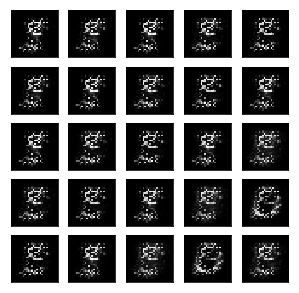

Epoch[6/25], G Loss: 0.3814, D Loss: 0.0299


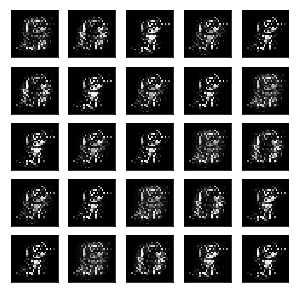

Epoch[7/25], G Loss: 0.3904, D Loss: 0.0348


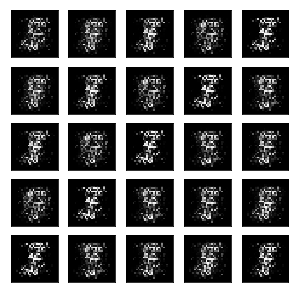

Epoch[8/25], G Loss: 0.3550, D Loss: 0.0779


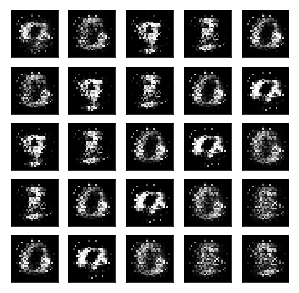

Epoch[9/25], G Loss: 0.3532, D Loss: 0.0698


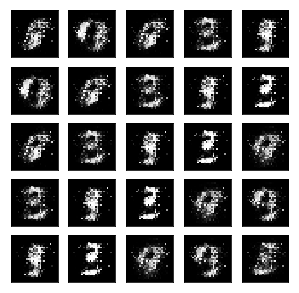

Epoch[10/25], G Loss: 0.3591, D Loss: 0.0556


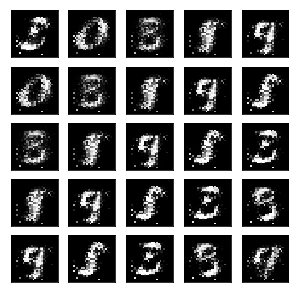

Epoch[11/25], G Loss: 0.3745, D Loss: 0.0438


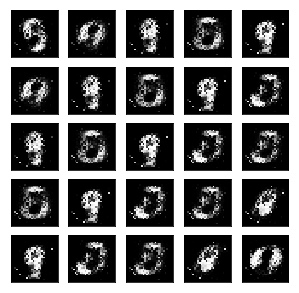

Epoch[12/25], G Loss: 0.3745, D Loss: 0.0461


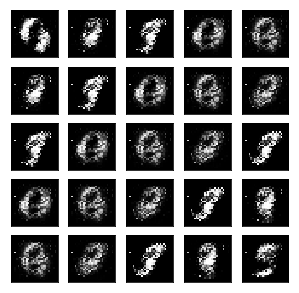

Epoch[13/25], G Loss: 0.3652, D Loss: 0.0481


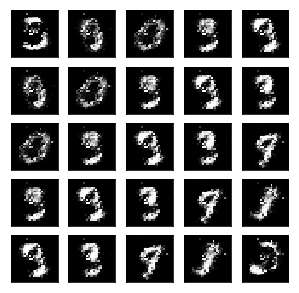

Epoch[14/25], G Loss: 0.3721, D Loss: 0.0430


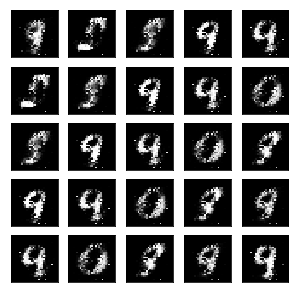

Epoch[15/25], G Loss: 0.3647, D Loss: 0.0479


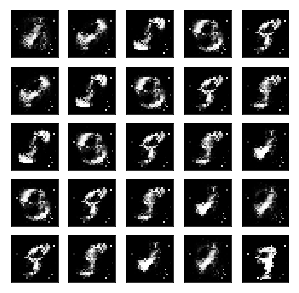

Epoch[16/25], G Loss: 0.3696, D Loss: 0.0431


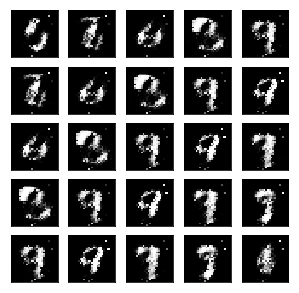

Epoch[17/25], G Loss: 0.3657, D Loss: 0.0432


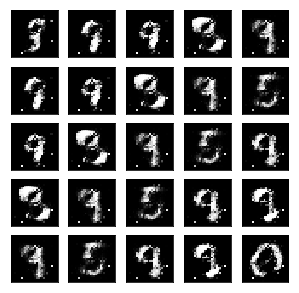

Epoch[18/25], G Loss: 0.3697, D Loss: 0.0440


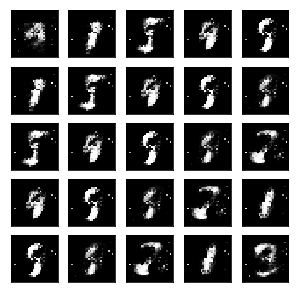

Epoch[19/25], G Loss: 0.3635, D Loss: 0.0486


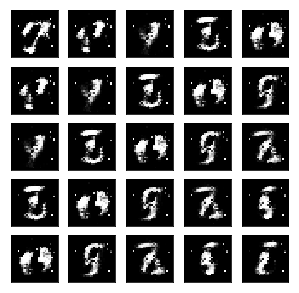

Epoch[20/25], G Loss: 0.3739, D Loss: 0.0423


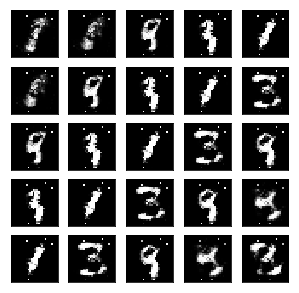

Epoch[21/25], G Loss: 0.3728, D Loss: 0.0444


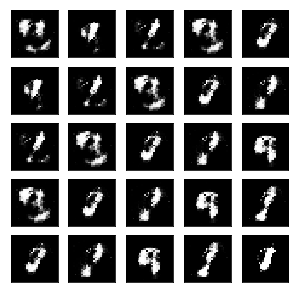

Epoch[22/25], G Loss: 0.3533, D Loss: 0.0546


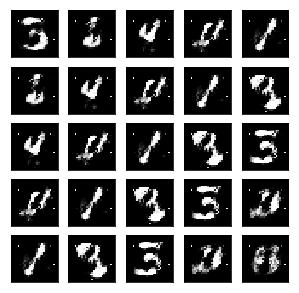

Epoch[23/25], G Loss: 0.3626, D Loss: 0.0514


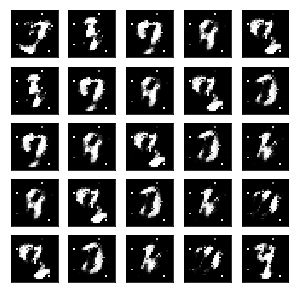

Epoch[24/25], G Loss: 0.3667, D Loss: 0.0477


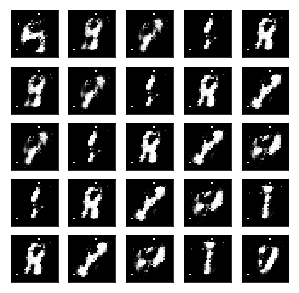

Epoch[25/25], G Loss: 0.3819, D Loss: 0.0398


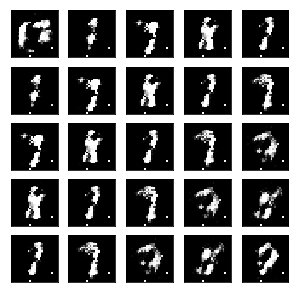

In [24]:
model = LSGAN(image_size = 784, hidden_dim = 256, z_dim = 128)
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 25, G_lr = 1e-4, D_lr = 1e-4, D_steps = 1)